# **Stage 1**: Train PPO on PointMaze with standard rewards, collect data, train distance models


In [1]:
import gymnasium as gym
import gymnasium_robotics
import numpy as np
import torch
import os

import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.env_wrappers import EnvBuilder
from src import ppo_agent, distance_models
from src.utils import trajectories_to_dataset

# Check for GPU
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4080 Laptop GPU


In [2]:
env_id = 'PointMaze_UMaze-v3'  # Use dense reward for initial training
train_episodes = 100
max_episode_steps = 512
seed = 0

torch.manual_seed(seed); np.random.seed(seed)
gym.register_envs(gymnasium_robotics)

# Initialize environment
c = 'c'; U_map = [
    [1, 1, 1, 1, 1],
    [1, c, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, c, 0, 0, 1],
    [1, 1, 1, 1, 1]
]
builder = EnvBuilder(env_id=env_id, maze_map=U_map, max_episode_steps=max_episode_steps, seed=seed)
obs_dim, act_dim = builder.get_obs_act_dim()
agent = ppo_agent.PPOAgent(state_dim=obs_dim, action_dim=act_dim, wandb_name="stage1")

wandb: Currently logged in as: voronov_artem_lit (voronov_artem_lit-skolkovo-institute-of-science-and-tech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
# Train
env = builder()
agent.train_ppo(env, num_episodes=train_episodes, max_episode_steps=max_episode_steps)

Training: 100%|███████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.47it/s]


In [4]:
# Evaluate
eval_env = builder()

trajectories = agent.evaluate_ppo(eval_env)
torch.save(agent.ac.state_dict(), "models/ppo_agent_stage1.pth")

eval_env.demonstrate(agent)

Evaluating: 100%|█████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.83it/s]


Over 100 eval episodes, 0 were successful (0.0%)


___

## Generate dataset
___

In [5]:
dataset = trajectories_to_dataset(trajectories)
print(f"Dataset size: {len(dataset['travel_distance'])} samples")

Building dataset: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 21.92it/s]


Dataset size: 4515000 samples


In [6]:
# Stack source and target positions together: [x_src, y_src, x_tgt, y_tgt]
sup_states = np.stack([
    dataset["source_x"],
    dataset["source_y"],
    dataset["target_x"],
    dataset["target_y"]
], axis=1)  # shape: (N, 4)

sup_distances = dataset["travel_distance"]  # shape: (N,)

In [9]:
# Concatenate into a single array for shuffling
full_data = np.hstack([
    sup_states,                          # shape (N, 4)
    sup_distances[:, np.newaxis]        # shape (N, 1)
])  # shape (N, 5)

# Shuffle rows
np.random.shuffle(full_data)

N = 23000
# Split back into states and distances
shuffled_states = full_data[:N, :4]
shuffled_distances = full_data[:N, 4]

# Train/eval split
split_ratio = 0.8
split_idx = int(len(shuffled_states) * split_ratio)

train_states = shuffled_states[:split_idx]
train_distances = shuffled_distances[:split_idx]

eval_states = shuffled_states[split_idx:]
eval_distances = shuffled_distances[split_idx:]

In [10]:
sup_model = distance_models.SupervisedDistanceEstimator(input_dim=4)
sup_loss = sup_model.train_from_data(train_states, train_distances, epochs=100)


Training distance model: 100%|████████████████████████████████████| 100/100 [00:20<00:00,  4.91it/s]


In [11]:
with torch.no_grad():
    inputs = torch.tensor(eval_states, dtype=torch.float32)
    targets = torch.tensor(eval_distances, dtype=torch.float32).unsqueeze(1)
    preds = sup_model.forward(inputs)
    eval_loss = sup_model.loss_fn(preds, targets).item()
print(f"Eval loss: {eval_loss:.4f}")

Eval loss: 0.0001


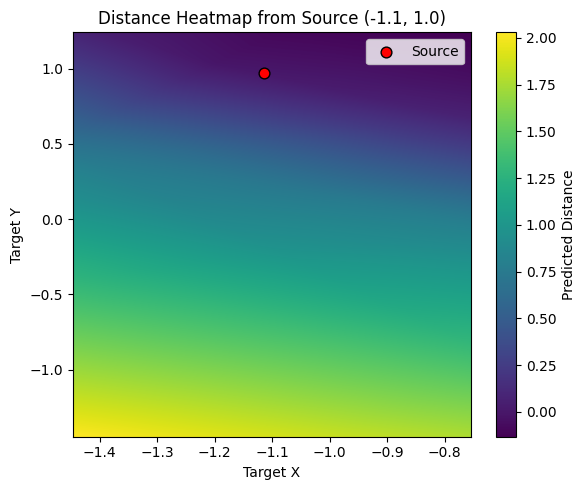

In [45]:
def get_borders(trajectories):
    all_points = np.concatenate([np.array(traj) for traj in trajectories], axis=0)
    x_all, y_all = all_points[:, 0], all_points[:, 1]
    
    xlim = (x_all.min(), x_all.max())
    ylim = (y_all.min(), y_all.max())
    start_point = tuple(trajectories[0][0])

    return start_point, xlim, ylim

start_point, xlim, ylim = get_borders(trajectories)
sup_model.plot_distance_heatmap(source_point=start_point, grid_size=1000, xlim=xlim, ylim=ylim)


In [ ]:
# # Train distance estimators on the collected data
# sup_model = distance_models.SupervisedDistanceEstimator(input_dim=4)
# sup_loss = sup_model.train_from_data(sup_states, sup_distances, epochs=100)
# # td_model = distance_models.TDDistanceEstimator(input_dim=obs_dim)
# # td_loss = td_model.train_from_transitions(td_transitions, epochs=100)
# # Compare models on the supervised dataset
# sup_preds = sup_model.model(torch.tensor(sup_states)).detach().numpy().flatten()
# # td_preds = td_model.model(torch.tensor(sup_states)).detach().numpy().flatten()
# mse_sup = np.mean((sup_preds - sup_distances)**2)
# # mse_td = np.mean((td_preds - sup_distances)**2)

# print(f"Supervised model MSE on training data: {mse_sup:.4f}")
# # print(f"TD model MSE on training data: {mse_td:.4f}")

# # Save models for Stage 2
# # torch.save(td_model.state_dict(), "models/distance_model_td.pth")
# torch.save(sup_model.state_dict(), "models/distance_model_sup.pth")
# torch.save(agent.ac.state_dict(), "models/ppo_agent_stage1.pth")
